<a href="https://colab.research.google.com/github/nitrogenlab/pyompa/blob/dev/examples/Revisit_Evans_et_al_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Replicate Falkor data analysis for intermediate waters from Evans et al. 2020, and demonstrate improvements from using PYOMPA's hard mass conservation constraint.  

Reference for Evans et al: https://aslopubs.onlinelibrary.wiley.com/doi/abs/10.1002/lno.11412

Install pyompa and gsw

In [1]:
!pip install pyompa==0.4.2.0
!pip install gsw

  Created wheel for pyompa: filename=pyompa-0.4.2.0-py3-none-any.whl size=27944 sha256=2520472bc726a9d578f180f07c1de5d28695628e379abe08201e88f7979a6aae
  Stored in directory: /root/.cache/pip/wheels/ee/bf/52/4e3078948c0fc6eacfffc76536a754087fb12697781430ecec
Successfully built pyompa
     |████████████████████████████████| 2.4 MB 5.2 MB/s 


In [2]:
#Alternative for installing pyompa from dev branch:

#!pip uninstall -y pyompa
#%cd /content/
#!rm -rf pyompa
#!git clone https://github.com/nitrogenlab/pyompa
#%cd /content/pyompa
#!git checkout dev
#!git log -1
#!pip install .
#%cd /content/

#%reload_ext autoreload
#%autoreload 2
#from importlib import reload
#import pyompa
#reload(pyompa)

Download the input data (this was provided by Natalya Evans)

In [3]:
!wget https://raw.githubusercontent.com/nitrogenlab/pyompa/cee3123/examples/FK_ompa_04s.mat -O FK_ompa_04s.mat

--2022-02-28 15:44:24--  https://raw.githubusercontent.com/nitrogenlab/pyompa/cee3123/examples/FK_ompa_04s.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38252 (37K) [application/octet-stream]
Saving to: ‘FK_ompa_04s.mat’

FK_ompa_04s.mat     100%[===================>]  37.36K  --.-KB/s    in 0.003s  

2022-02-28 15:44:25 (11.8 MB/s) - ‘FK_ompa_04s.mat’ saved [38252/38252]



Load the input data

In [4]:
import scipy.io
from scipy.io import loadmat
import pandas as pd
import numpy as np

inp_data = loadmat("FK_ompa_04s.mat")

#Prepare a data frame for the Falkor data

falkor_df = pd.DataFrame({
    'lat': inp_data['lat'].flatten(),
    'long': inp_data['long'].flatten(),
    'pdens': inp_data['pdens'].flatten(),
    'pressure': inp_data['press'].flatten(),
    'Iodate': inp_data['Iodate'].flatten(),
    'Iodide': inp_data['Iodide'].flatten(),
    'nitrate': inp_data['NO2'].flatten(),
    'oxygen': inp_data['oxy'].flatten(),
    'phosphate': inp_data['ph'].flatten(),
    'conservative_temp': inp_data['ptemp'].flatten(),
    'absolute_salinity': inp_data['sal'].flatten(),
    #Note: although spiceness was included in this
    # work, because spiciness is computed from
    # temperature and salinity, including it does
    # not improve the results; also, spiciness is
    # stored under 'pvort' for technical reasons
    # pertaining to the MATALB OMP implementation
    #Also, the MATLAB implementation takes the absolute
    # value of the potential vorticity, so we
    # do that here as well
    'spiciness': np.abs(inp_data['pvort'].flatten())
})
#If we were using the hard mass conservation constraint, it would not be
# necessary to specify this "mass" variable; however, to replicate the MATLAB
# OMP analysis, we have to create a separate variable for mass
falkor_df["mass"] = 1.0

#Filter the data frame to density ranges used for intermedite waters
intermediatewaters_falkordf = pd.DataFrame(
    falkor_df[(falkor_df["pdens"] >= 26.0)
              & (falkor_df["pdens"] <= 27.0)])

Define the end-members

In [5]:
#                                   temp       sal         oxy     PO4     NO3    Si      spic
CW13_FK =        ["13CW_FK",       12.54,    34.98,       0.59,   2.73,   23.2,   50,     1.58]
NEPIW_FK =       ["NEPIW_FK",       9.56,    34.80,       0.64,   3.1,    35,     50,     0.894]
AAIW =           ["AAIW",           6.03,    34.70,       4.8,    3.48,   46.8,   60,     0.418]

def prepare_endmember_df(endmembers_arr):
    df = pd.DataFrame(data=endmembers_arr,
                      columns=["endmember_name", "conservative_temp", "absolute_salinity",
                               "oxygen", "phosphate", "nitrate", "silicate", "spiciness"])
    df["mass"] = 1
    return df

intermediatewaters_FK_endmemberdf = prepare_endmember_df(
    [CW13_FK, NEPIW_FK, AAIW])


Define the pyompa parameters to replicate the matlab OMP analysis, and run the analysis

In [6]:
import pyompa

#Define a parameter to represent remineralization in terms of phosphate
# The ratio of oxygen:phosphate specified is -170:1, that is 170 moles of
# oxygen consumed for each mole of oxygen produced.
evansorig_convertedparamgroups = [
    pyompa.ConvertedParamGroup(
        groupname="phosphate_remin",
        conversion_ratios=[{"oxygen": -170, "phosphate": 1.0}],
        always_positive=True #The MATLAB OMP implementation enforces a positive
        # value for the delta P variable, meaning it can only model
        # remineralization. Change to False (the default) to also model
        # assimilation.
        )
]

evansorig_paramweightings = {
    "conservative_temp": 24.0,
    "absolute_salinity": 24.0,
    "spiciness": 7.0,
    "mass": 24.0,
    "oxygen": 7.0,
    "phosphate": 2.0
}

evansorig_settings = {
    "param_names": ["conservative_temp", "absolute_salinity",
                    "oxygen", "phosphate", "spiciness", "mass"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    #setting sumtooneconstraint to False replicates the behavior of the
    # MATLAB OMP implementation, which does not enforce mass conservation.
    # By default, sumtooneconstraint is True in pyompa.
    "sumtooneconstraint": False,
    #standardize_by_watertypes=True replicates the normalization behavior
    # of the MATLAB OMP implementation. By default, this is False.
    "standardize_by_watertypes": True
}

#Run the analysis, replicating the MATLAB OMP analysis
orig_intermediate_falkordf_ompasoln = pyompa.OMPAProblem(
  obs_df = intermediatewaters_falkordf,
  **evansorig_settings).solve(
      intermediatewaters_FK_endmemberdf,
      endmember_name_column="endmember_name")

Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
I'm assuming that the index encoding mass is: [5]
Std used for normalization: [3.25886995 0.14189198 2.41634021 0.37501111 0.58415409 1.        ]
Mean used for normalization: [ 9.37666667 34.82666667  2.01        3.10333333  0.964       0.        ]
params to use: ['conservative_temp', 'absolute_salinity', 'oxygen', 'phosphate', 'spiciness', 'mass']
param weighting: [24. 24.  7.  2.  7. 24.]
effective weighting: [  7.36451604 169.14275486   2.89694306   5.33317532  11.9831396
  24.        ]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 279 out of 279
status: optimal
optimal value 11163.592733801042
Original weighted sum squares: 11163.592733816386
Post fix weighted sum squared: 11163.592733831858
On example 0 to 279 out of 279
status: optimal
optimal value 11163.592733801042
Original weighted sum squares: 11163.592733816386
Post fix weighted sum squared: 11163.592733831858
obj

Display the results that replicate the original MATLAB OMP analysis - note the large salinity residuals (up to 6; these occur at locations that likely suffer from a missing end-member), and how the large salinity residuals line up with the residuals in mass conservation.

Orignal MATLAB OMP - Water mass fractions and deltaP


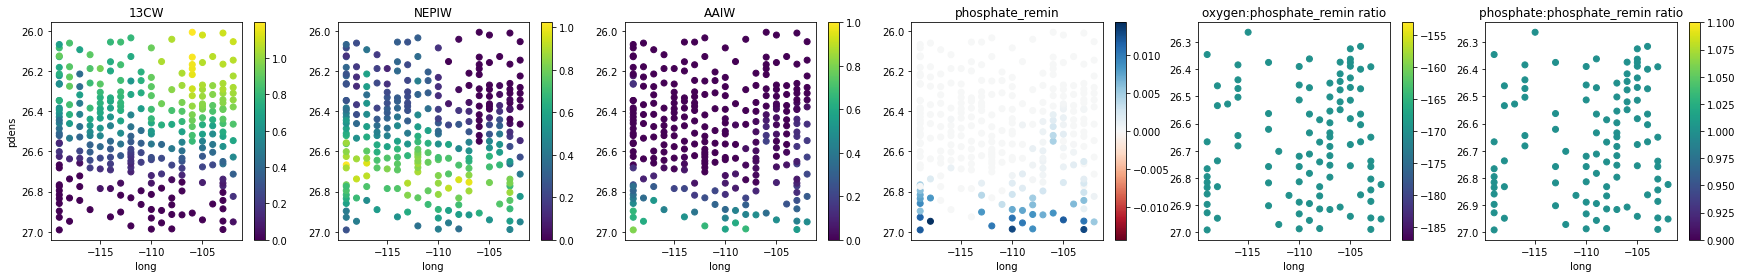

Original MATLAB OMP - Residuals


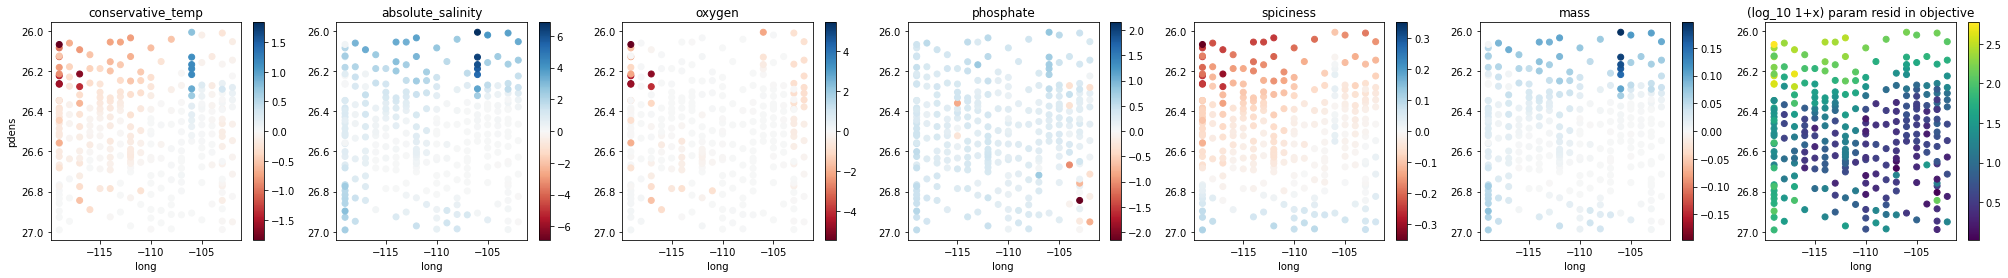

In [7]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "pdens"
print("Orignal MATLAB OMP - Water mass fractions and deltaP")
plot_ompasoln_endmember_fractions(ompa_soln=orig_intermediate_falkordf_ompasoln,
                                  xaxis_colname="long",
                                  yaxis_colname=yaxis_colname)
print("Original MATLAB OMP - Residuals")
plot_ompasoln_residuals(ompa_soln=orig_intermediate_falkordf_ompasoln,
                        xaxis_colname="long",
                        yaxis_colname=yaxis_colname)

Also verify that the results are numerically equivalent to the results provided by the authors

In [8]:
#Download the results that Talia sent over
!wget https://raw.githubusercontent.com/nitrogenlab/pyompa/cee3123/examples/FK_26_27_s.mat -O FK_26_27_s.mat

#Load the results in and compare - verify differences are
# numerically equivalent to 0
matlab_omp_results = loadmat("FK_26_27_s.mat")
#Check that the water mass fractions are equivalent
print(np.max(np.abs(orig_intermediate_falkordf_ompasoln.endmember_fractions
                    - matlab_omp_results['A'].T)))
#Check that the phosphate remineralization values are equivalent
print(np.max(np.abs(orig_intermediate_falkordf_ompasoln
                    .groupname_to_totalconvertedvariable['phosphate_remin']*170
                    - matlab_omp_results['biogeo'].flatten())))
#Check that the residuals are equivalent
np.max(np.abs(orig_intermediate_falkordf_ompasoln.param_residuals
              - matlab_omp_results['err'].T))

--2022-02-28 15:44:31--  https://raw.githubusercontent.com/nitrogenlab/pyompa/cee3123/examples/FK_26_27_s.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32696 (32K) [application/octet-stream]
Saving to: ‘FK_26_27_s.mat’

FK_26_27_s.mat      100%[===================>]  31.93K  --.-KB/s    in 0.002s  

2022-02-28 15:44:31 (13.1 MB/s) - ‘FK_26_27_s.mat’ saved [32696/32696]

1.9569901255067634e-12
3.4418427376578365e-14


5.118749868415762e-11

Do a new analysis, this time imposing a hard constraint on mass conservation

In [9]:
hardmasscons_settings = {
    "param_names": ["conservative_temp", "absolute_salinity",
                    "oxygen", "phosphate", "spiciness", "mass"],
    "param_weightings": evansorig_paramweightings,
    "convertedparam_groups": evansorig_convertedparamgroups,
    #The difference here is that sumtooneconstraint is True
    "sumtooneconstraint": True,
    "standardize_by_watertypes": True
}

#Run the analysis with the hard mass conservation constraint
hardmasscons_intermediate_falkordf_ompasoln = pyompa.OMPAProblem(
  obs_df = intermediatewaters_falkordf,
  **hardmasscons_settings).solve(
      intermediatewaters_FK_endmemberdf,
      endmember_name_column="endmember_name")

Endmember-idx mapping is
 OrderedDict([('13CW', [0]), ('NEPIW', [1]), ('AAIW', [2])])
I'm assuming that the index encoding mass is: [5]
Std used for normalization: [3.25886995 0.14189198 2.41634021 0.37501111 0.58415409 1.        ]
Mean used for normalization: [ 9.37666667 34.82666667  2.01        3.10333333  0.964       0.        ]
params to use: ['conservative_temp', 'absolute_salinity', 'oxygen', 'phosphate', 'spiciness', 'mass']
param weighting: [24. 24.  7.  2.  7. 24.]
effective weighting: [  7.36451604 169.14275486   2.89694306   5.33317532  11.9831396
  24.        ]
Matrix A:
Trying convertedvariable sign constraint: [1]
On example 0 to 279 out of 279
status: optimal
optimal value 11739.965032789956
Original weighted sum squares: 11739.965032805427
Post fix weighted sum squared: 11739.965032821146
On example 0 to 279 out of 279
status: optimal
optimal value 11739.965032789956
Original weighted sum squares: 11739.965032805427
Post fix weighted sum squared: 11739.965032821146
obj

Display the results with the hard mass conservation cosntraint; note the improvement in the salinity residuals (now on the order of 0.06)

Hard mass conservation - Water mass fractions and deltaP


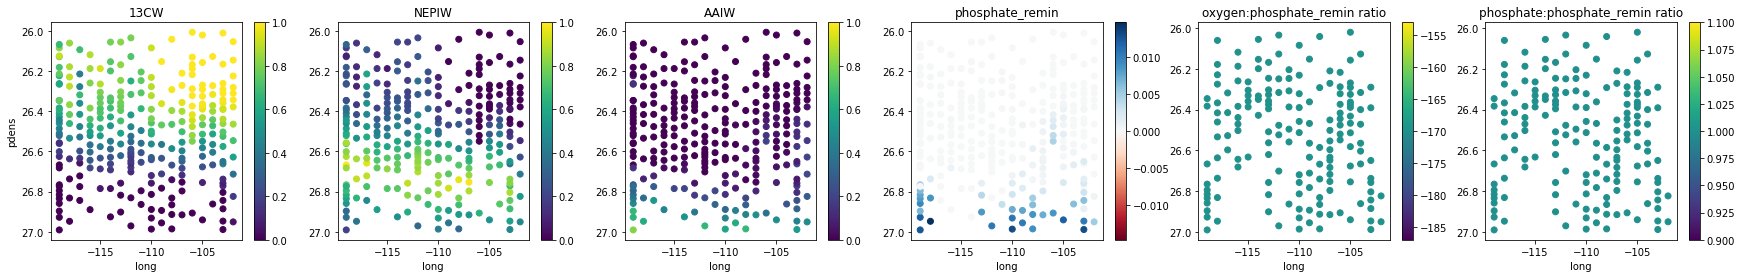

Hard mass conservation - Residuals


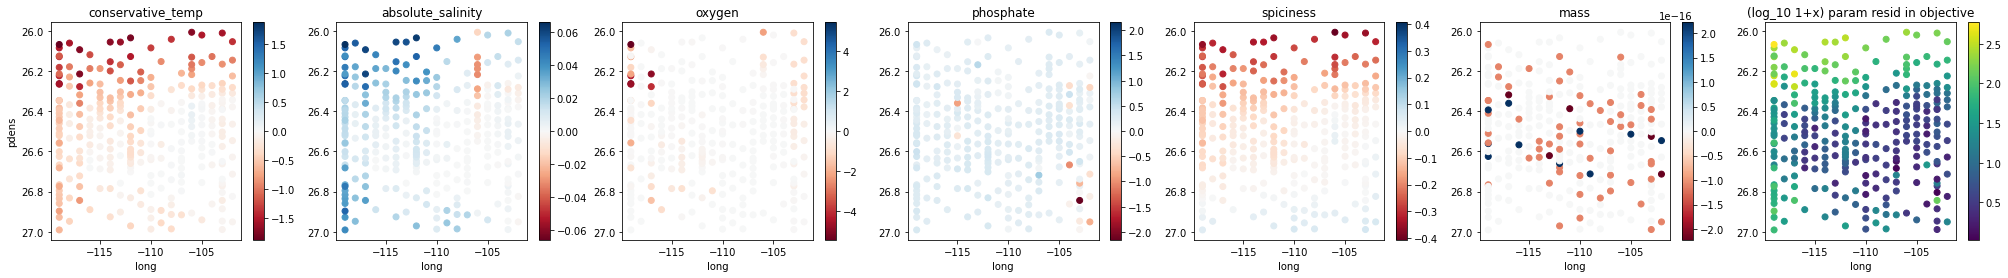

In [10]:
from matplotlib import pyplot as plt
from pyompa import (plot_ompasoln_endmember_fractions,                       
                    plot_ompasoln_residuals,                                 
                    plot_ompasoln_endmember_usagepenalties)

yaxis_colname = "pdens"
print("Hard mass conservation - Water mass fractions and deltaP")
plot_ompasoln_endmember_fractions(
    ompa_soln=hardmasscons_intermediate_falkordf_ompasoln,
    xaxis_colname="long",
    yaxis_colname=yaxis_colname)
print("Hard mass conservation - Residuals")
plot_ompasoln_residuals(ompa_soln=hardmasscons_intermediate_falkordf_ompasoln,
                        xaxis_colname="long",
                        yaxis_colname=yaxis_colname)